# Spatial comparisons
---  
*J. Michelle Hu  
University of Utah  
Aug 2024*  


In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyproj
import geopandas as gpd
import xarray as xr
# import hvplot.xarray

from s3fs import S3FileSystem, S3Map

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/envs/studio/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
%reload_ext autoreload
%autoreload 2

### Env setup

In [3]:
from pathlib import PurePath
# Locate pyproj_datadir for studio env
# From https://stackoverflow.com/questions/69630630/on-fresh-conda-installation-of-pyproj-pyproj-unable-to-set-database-path-pypr
CONDA_ENV = 'studio'
miniconda_dir = '/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3'
proj_version = h.fn_list(miniconda_dir, f'envs/{CONDA_ENV}/conda-meta/proj-[0-9]*.json')[0]

VERSION = PurePath(proj_version).stem
# print(proj_version)
# print(VERSION)

# /uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.4.1-h54d7996_1/share/proj
pyprojdatadir = f'{miniconda_dir}/pkgs/{VERSION}/share/proj'
print(pyprojdatadir)
pyproj.datadir.set_data_dir(pyprojdatadir)

# # Set environmental variable for PROJ to directory where you can find proj.db
# os.environ['PROJ']=pyprojdatadir
# os.environ['PROJLIB']=pyprojdatadir

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.4.1-h54d7996_1/share/proj


### Directories and global variables

In [4]:
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/'
script_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/isnobal_scripts'
poly_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/polys'
aso_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/ASO'

# SNOTEL all sites geojson fn - snotel site json
allsites_fn = '/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL/snotel_sites_32613.json'

# nwm proj4 file
proj_fn = "/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/NWM_datasets_proj4.txt"

In [5]:
# Basin-specific variables
basin = 'blue'

In [6]:
if basin == 'blue':
    basindirs = [h.fn_list(workdir, f'*{basin}*')[1], h.fn_list(workdir, f'*{basin}*')[0]] # Blue River
elif basin == 'yampa':
    # basindirs =h.fn_list(workdir, f'__{basin}*') # Yampa River previous runs
    basindirs =h.fn_list(workdir, f'{basin}*') # Yampa River newest runs
elif basin == 'animas':
    basindirs = h.fn_list(workdir, f'__{basin}*') # Animas previous runs
    # basindirs = [h.fn_list(workdir, f'{basin}*')[0], h.fn_list(workdir, f'__{basin}*')[1]]
basindirs

['/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_river_100m_isnobal',
 '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/__blue_river_100m_isnobal_solar_albedo']

In [7]:
# Get the WY from the directory name - assumes there is only one WY per basin
WY = int(h.fn_list(basindirs[0], '*')[0].split('/')[-1].split('wy')[-1])
print(WY)

# Figure out filenames
# Basin polygon file if not in poly_dir, all should now be there
# poly_fn = h.fn_list(script_dir, f'*{basin}*setup/polys/*shp')[0]
poly_fn = h.fn_list(poly_dir, f'*{basin}*shp')[0]
print(poly_fn)

2019
/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/ancillary/polys/blue_river_basin_outline_HUC10dissolved_32613.shp


## ASO

In [8]:
state = 'CO'
# basinname = 'Blue' # more recent collections
if basin == 'blue':
    basinname = 'USCOBR' # older NSIDC collections 
else:
    basinname = basin.capitalize()
basinname

'USCOBR'

In [9]:
# Water year collections should all be post January so this should work
aso_depth_fns = h.fn_list(aso_dir, f'{state}/*{basinname}*{WY}*tif')

# Load depth arrays and squeeze out single dimensions
aso_depth_list = [np.squeeze(xr.open_dataset(fn)) for fn in aso_depth_fns]

# Rename band_data to descriptive snow_depth
aso_depth_list = [ds.rename_vars({'band_data': 'snow_depth'}) for ds in aso_depth_list]

# Deal with adding time input for ASO data

if basin == 'blue':
    inputvar = '.'
elif basin == 'animas':
    inputvar = '_snowdepth'

aso_depth_list = [np.squeeze(proc.assign_dt(ds, proc.extract_dt(fn, inputvar=inputvar))) for ds, fn in zip(aso_depth_list, aso_depth_fns)]

print(aso_depth_fns)

['/uufs/chpc.utah.edu/common/home/skiles-group3/ASO/CO/ASO_50M_SD_USCOBR_20190419.tif', '/uufs/chpc.utah.edu/common/home/skiles-group3/ASO/CO/ASO_50M_SD_USCOBR_20190624.tif']


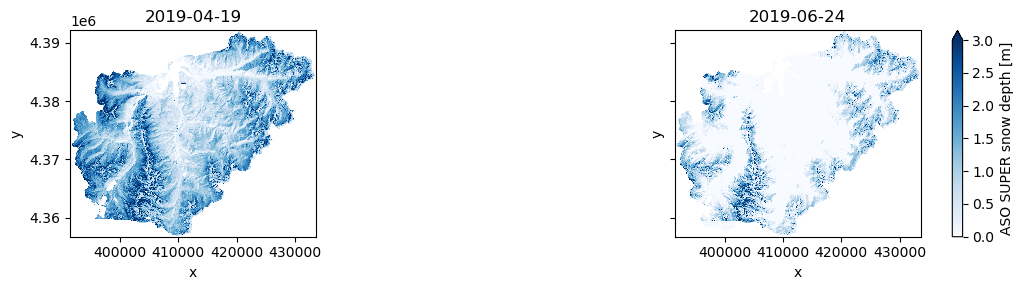

In [10]:
cmap = 'Blues'
titles = [pd.to_datetime(depth.time.values).strftime('%Y-%m-%d') for depth in aso_depth_list]
cbaron = [False, True]
figsize = (12,3)
vmin = 0
vmax = 3

# Plot the iSnobal snow depths 
fig, axa = plt.subplots(1, 2, sharex=True, sharey=True, figsize=figsize)
for jdx, depth in enumerate(aso_depth_list):
    depth['snow_depth'].plot.imshow(ax=axa[jdx], cmap=cmap, add_colorbar=cbaron[jdx], vmin=vmin, vmax=vmax)
    ax = axa[jdx]
    ax.set_aspect('equal')
    ax.set_title(titles[jdx])

plt.tight_layout()

## iSnobal bits

In [11]:
# Get dates, could easily just pull from filenames, but this is fine
date_list = [proc.extract_dt(fn, inputvar=inputvar)[0] for fn in aso_depth_fns]
date_list = [f.strftime('%Y-%m-%d') for f in date_list]
date_list

['2019-04-19', '2019-06-24']

In [12]:
# Based on validation timesteps, select a time slice
# Blue River ASO dates -- move iSnobal after ASO bits
ddx = 0
dt = date_list[ddx]
# dt = '2019-06-24'

# convert to datetime object
dt = np.datetime64(dt)

['/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_river_100m_isnobal/wy2019/blue_river_basin_100m/run20190419', '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/__blue_river_100m_isnobal_solar_albedo/wy2019/blue_river_basin_100m/run20190419']
['/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_river_100m_isnobal/wy2019/blue_river_basin_100m/run20190419/snow.nc', '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/__blue_river_100m_isnobal_solar_albedo/wy2019/blue_river_basin_100m/run20190419/snow.nc']


ERROR 1: PROJ: proj_create_from_database: /uufs/chpc.utah.edu/sys/spack/linux-rocky8-nehalem/gcc-8.5.0/proj-8.1.0-usmhdefwvs6hvlo55oavx2t5x6xfarjz/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 3 is expected. It comes from another PROJ installation.
ERROR 1: PROJ: proj_create_from_database: /uufs/chpc.utah.edu/sys/spack/linux-rocky8-nehalem/gcc-8.5.0/proj-8.1.0-usmhdefwvs6hvlo55oavx2t5x6xfarjz/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 3 is expected. It comes from another PROJ installation.


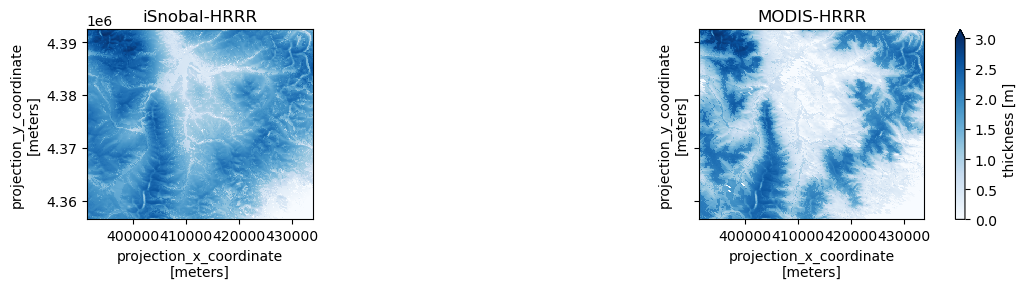

In [13]:
# find isnobal output and compare directly
isnobal_rundirs = [h.fn_list(basindir, f"*/*/run{''.join(str(dt).split('-'))}")[0] for basindir in basindirs]
print(isnobal_rundirs)

# Read in snow depths and plot
depth_fns = [proc.fn_list(sdir, "snow.nc")[0] for sdir in isnobal_rundirs]
print(depth_fns)

# Open snow depth files
depths = [np.squeeze(xr.open_mfdataset(depth_fn, decode_coords="all")['thickness']) for depth_fn in depth_fns]

# Set CRS for iSnobal output
depths = [depth.rio.write_crs('epsg:32613', inplace=True) for depth in depths]

cmap = 'Blues'
titles = ['iSnobal-HRRR', 'MODIS-HRRR']
cbaron = [False, True]
figsize = (12,3)

# Plot the iSnobal snow depths 
fig, axa = plt.subplots(1, 2, sharex=True, sharey=True, figsize=figsize)
for jdx, depth in enumerate(depths):
    depth.plot.imshow(ax=axa[jdx], cmap=cmap, add_colorbar=cbaron[jdx], vmin=vmin, vmax=vmax)
    ax = axa[jdx]
    ax.set_aspect('equal')
    ax.set_title(titles[jdx])

plt.tight_layout()

## NWM

+proj=lcc +lat_0=40 +lon_0=-97 +lat_1=30 +lat_2=60 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs


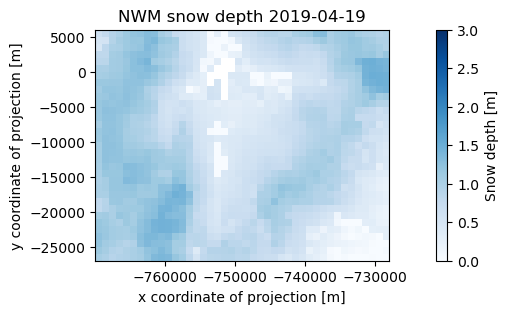

In [14]:
bucket = 's3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr'
fs = S3FileSystem(anon=True)
ds = xr.open_dataset(S3Map(f"{bucket}/ldasout.zarr", s3=fs), engine='zarr')

# Read in NWM proj4 string
with open(proj_fn, "r") as f:
    proj4 = f.read()
print(proj4)

# Read in poly_fn for spatial slicing
epsg = 'epsg:32613'
poly_gdf = gpd.read_file(poly_fn)
poly_gdf.set_crs(epsg, inplace=True, allow_override=True)

# Convert to NWM proj4 coords
poly_gdf = poly_gdf.to_crs(crs=proj4)

# Crop the dataset to the input polygon extent
var = 'SNOWH'
cropped_ds = ds.sel(x=slice(poly_gdf.bounds.minx.values[0], poly_gdf.bounds.maxx.values[0]), 
                    y=slice(poly_gdf.bounds.miny.values[0], poly_gdf.bounds.maxy.values[0]))

# Slice time from NWM spatial crop
nwm_depth = cropped_ds[var].sel(time=dt)

# Establish CRS inplace
nwm_depth = nwm_depth.rio.write_crs(input_crs=proj4, inplace=True)

# Plot the iSnobal snow depths 
fig, ax = plt.subplots(1, figsize=figsize)
nwm_depth.plot.imshow(ax=ax, cmap=cmap, add_colorbar=cbaron[jdx], vmin=vmin, vmax=vmax)
ax.set_aspect('equal')
ax.set_title(f'NWM snow depth {pd.to_datetime(nwm_depth.time.values).strftime('%Y-%m-%d')}');

ERROR 1: PROJ: proj_identify: /uufs/chpc.utah.edu/sys/spack/linux-rocky8-nehalem/gcc-8.5.0/proj-8.1.0-usmhdefwvs6hvlo55oavx2t5x6xfarjz/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 3 is expected. It comes from another PROJ installation.


PROJCS["WGS 84 / UTM zone 13N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32613"]]


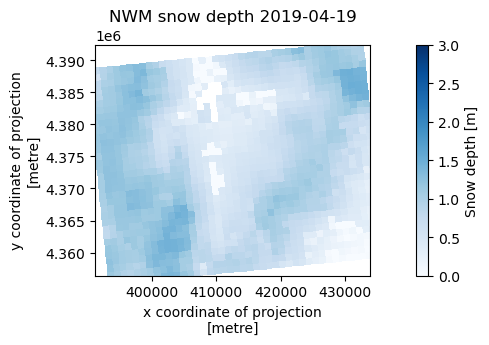

In [15]:
# Reproject to match iSnobal outputs for shared coord plotting
nwm_reproj = nwm_depth.rio.reproject_match(depth)
print(nwm_reproj.rio.crs)

# Plot the iSnobal snow depths 
fig, ax = plt.subplots(1, figsize=figsize)
nwm_reproj.plot.imshow(ax=ax, cmap=cmap, add_colorbar=cbaron[jdx], vmin=vmin, vmax=vmax)
ax.set_aspect('equal')
ax.set_title(f'NWM snow depth {pd.to_datetime(nwm_depth.time.values).strftime('%Y-%m-%d')}');

## Plot it all up

In [16]:
import seaborn as sns
sns.set_palette('icefire')

/scratch/local/u6058223/ipykernel_581/3502149161.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


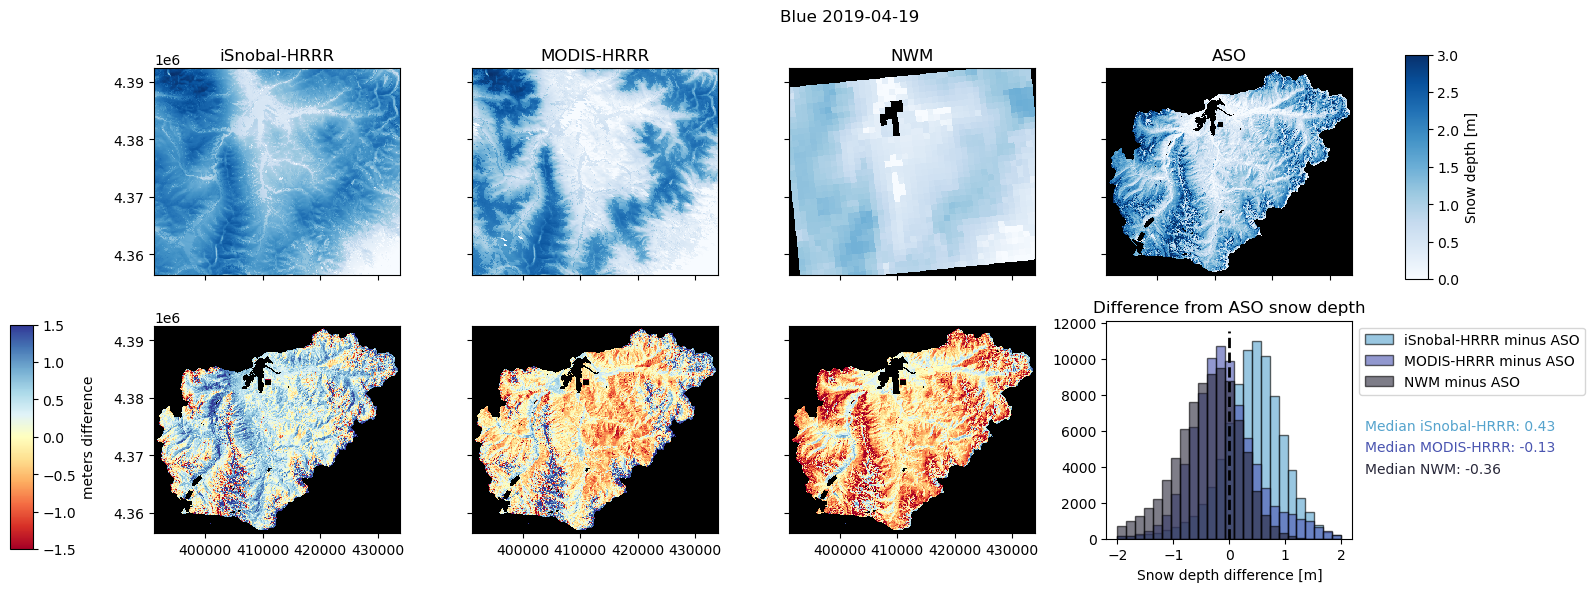

In [17]:
if basin == 'blue':
    figsize = (15, 6)
    nrows, ncols = 2, 4
    arrs = depths + [nwm_reproj] + [aso_depth_list[ddx]['snow_depth']]
    titles = ['iSnobal-HRRR', 'MODIS-HRRR', 'NWM', 'ASO']

elif basin == 'animas':
    figsize = (10, 6)
    nrows, ncols = 2, 3
    arrs = [depths[0]] + [nwm_reproj] + [aso_depth_list[ddx]['snow_depth']]
    titles = ['iSnobal-HRRR', 'NWM', 'ASO']

nbins = 25
alpha = 0.6
ec = 'k'
binrange = (-2, 2)
ys = [0.5, 0.4, 0.3]    
    
fig, axa = plt.subplots(nrows, ncols, figsize=figsize, sharex=True, sharey=True)

for kdx, arr in enumerate(arrs):
    ax = axa.flatten()[kdx]
    # arr.plot.imshow(ax=ax, cmap=cmap, add_colorbar=cbaron[kdx], vmin=vmin, vmax=vmax)
    im = arr.plot.imshow(ax=ax, cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(titles[kdx])
    ax.set_aspect('equal');
    ax.set_facecolor('k');
    # add a new colorbar using separate fig axis
    if kdx == len(arrs) - 1:
        cb_ax = fig.add_axes([0.87, 0.53, 0.015, 0.374])
        fig.colorbar(im, orientation='vertical', cax=cb_ax, label='Snow depth [m]')
    
plt.suptitle(f'{basin.capitalize()} {date_list[ddx]}');    

diff_dict = dict()
for ldx, arr in enumerate(arrs):
    ax = axa.flatten()[ldx + kdx + 1]
    if ldx == len(arrs) - 1:
        # Turn off existing axes that have shared coords
        ax.set_visible(False)
        
        # Add a brand new one to plot difference histograms
        ax = fig.add_subplot(2, 4, 8)
        for mdx, f in enumerate(diff_dict.keys()):
            med = np.nanmedian(diff_dict[f])
            diff_dict[f].plot.hist(range=binrange, bins=nbins, alpha=alpha, ec=ec, label=f'{f} minus ASO')
            ax.annotate(f'Median {f}: {med:.2f}', xycoords='axes fraction',
                        xy=(1.05, ys[mdx]),
                        ha='left', color=sns.color_palette()[mdx]
                       )
        ax.vlines(0, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='k', linestyle='--', linewidth=2)
        ax.set_title('Difference from ASO snow depth')
        ax.set_xlabel('Snow depth difference [m]')
        ax.legend(bbox_to_anchor=(1, 1))          
        break
    # Reproject and match ASO to comparison array
    aso_reproj = arrs[-1].rio.reproject_match(arr)
    
    # Compute diff
    diff = arr - aso_reproj
    
    # Store in dict
    diff_dict[titles[ldx]] = diff
    
    # Plot the diff
    diff_im = diff.plot.imshow(ax=ax, cmap='RdYlBu', add_colorbar=False, vmin=-vmax/2, vmax=vmax/2)
    
    if ldx == len(arrs) - 2:
        cb_ax = fig.add_axes([-0.06, 0.08, 0.015, 0.374])
        fig.colorbar(diff_im, orientation='vertical',cax=cb_ax, label='meters difference')

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
    ax.set_aspect('equal')
    ax.set_facecolor('k')

plt.tight_layout()

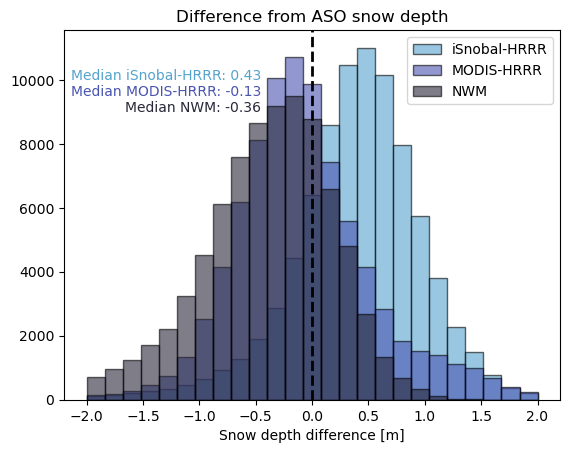

In [18]:
nbins = 25
alpha = 0.6
ec = 'k'
binrange = (-2, 2)
xs = [1.5, -1, -1.5]
ys = [10000, 9500, 9000]

fig, ax = plt.subplots()
for ldx, f in enumerate(diff_dict.keys()):
    med = np.nanmedian(diff_dict[f])
    diff_dict[f].plot.hist(range=binrange, bins=nbins, alpha=alpha, ec=ec, label=f)#label=f'{f}: ${med:.2f}$')
    ax.annotate(f'Median {f}: {med:.2f}', 
                xy=(-0.45, ys[ldx]),
                ha='right', color=sns.color_palette()[ldx]
                # xy=(xs[ldx], 8000)
                # xy=(med*3, ys[ldx])
               )

plt.axvline(0, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='k', linestyle='--', linewidth=2)
plt.title('Difference from ASO snow depth')
plt.xlabel('Snow depth difference [m]')
plt.legend()